# Réduction de variance et calcul de sensibilités

Sur on problème de modélisation classique en assurance, on illustre l'importance de l'erreur relative puis deux techniques de réduction de variance: 

- méthode par préconditionnement, 
- échantillonage d'importance (important pour les événements rares).

Dans une deuxième partie on s'intéresse aux sensibilités et comment implémenter efficacement la méthode des différences finies avec la méthode de Monte Carlo. 

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

## Charge sinistre et loi Poisson-composée

On définit la _charge sinistre totale_ (sur une période $T$) par la variable aléatoire positive
\begin{equation*}
    S = \sum_{i = 1}^N X_i
\end{equation*}
où $N$ est une variable aléatoire à valeurs dans $\mathbf{N}$ représentant le nombre de sinistres sur la période $T$, et pour $i \ge 1$, $X_i$ est une variable aléatoire à valeurs dans $\mathbf{R}_+$ représentant le coût du i-ème sinistre, avec la convention selon laquelle la somme est nulle si $N = 0$. Les $(X_i)_{i \ge 1}$ sont supposées indépendantes et identiquement distribuées, et indépendantes de $N$ (indépendance fréquences - coûts).

Une modélisation classique est de considérer 

- $N$ de loi de Poisson de paramètre $\lambda > 0$, 
- $X_1$ de loi log-normale de paramètres $\mu > 0$, $\sigma^2 > 0$, c'est à dire $X_1 = \exp(G_1)$ avec $G_1 \sim \mathcal{N}(\mu, \sigma^2)$. 

Le but est d'estimer la **probabilité de dépassement** c'est à dire calculer la probabilité que la charge sinistre totale dépasse un seuil $K$:
\begin{equation*}
    p = \mathbf{P}\bigl[S > K\bigr] \quad \text{pour $K$ grand}
\end{equation*}

Dans la suite on prend $\lambda = 10$, $\mu = 0.1$ et $\sigma = 0.3$ et on considère plusieurs valeurs du seuil $K$.

### Question: simulation de la charge sinistre totale 

Ecrire une fonction `simu_S(size, mu, sigma, lambd)` qui renvoie un échantillon de taille `size` de réalisations indépendantes de $S$.

In [2]:
def simu_S(size, mu, sigma, lambd):
    sample_N = rng.poisson(size=size,lam=lambd)
    sample_S = np.empty(size)

    for ind,N in enumerate(sample_N) :
        Xn = rng.lognormal(mean=mu, sigma=sigma, size=N)
        sample_S[ind] = np.sum(Xn)

    return sample_S

In [3]:
lmbda = 10
mu = 0.1
sigma = 0.3

### Question: représentation graphique 

Représenter l'histogramme d'un échantillon de $100\,000$ réalisations de $S$ et du seuil $K = 20$ par une ligne verticale rouge.

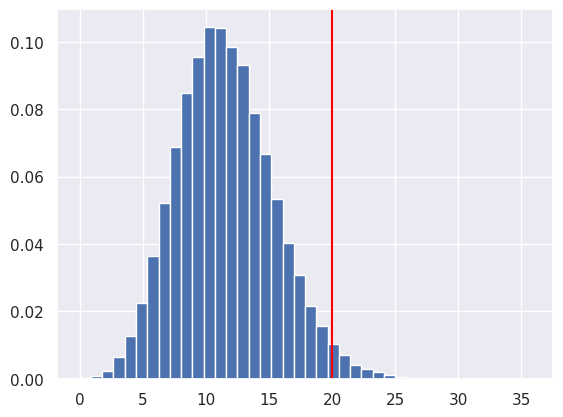

In [4]:
n = 100_000
K = 20

sample_S = simu_S(n, mu, sigma, lmbda)

plt.hist(sample_S, bins=40, density=True)
plt.axvline(K, color="red")
plt.show()

## Estimateur Monte Carlo et erreur relative 

Soit $p_n = \displaystyle \frac{1}{n} \sum_{j=1}^n \mathbf{1}_{S^{(j)} > K}$ l'estimateur Monte Carlo de $p= \mathbf{P}\bigl[S > K\bigr]$ où $(S^{(j)})_{j=1,\dots,n}$ est une suite _i.i.d._ de même loi que $S$.

On rappelle que:

- l'**erreur absolue** de l'estimateur Monte Carlo $p_n$ est définie par $|p_n - p|$ et qu'avec probabilité 0.95 cette erreur est bornée par $e_n = 1.96 \frac{\sigma_n}{\sqrt{n}}$ avec $\sigma_n^2 = p_n - p_n^2$,
- l'**erreur relative** de l'estimateur Monte Carlo est définie par $\frac{|p_n - p|}{p}$ que l'on majore avec probabilité 0.95 par $\frac{e_n}{p_n}$.

### Question: erreur relative 

Ecrire une fonction `relative_error` qui à partir d'un échantillon de $S$ (de taille $n$) et d'une valeur de seuil $K$ renvoie la probabilité $p_n$ et l'erreur relative (plus exactement la borne $\frac{e_n}{p_n}$ à 95%). 

Tracer l'erreur relative d'un échantillon de taille $100\,000$ en fonction de $K$ pour $K$ allant de 20 à 30. Comment interpréter cette courbe? 

In [5]:
def relative_error(sample_S, K):
    taille = sample_S.shape[0]
    pn = np.mean(sample_S > K)
    en = 1.96*np.sqrt((pn-pn**2) / taille)

    return pn, en/pn

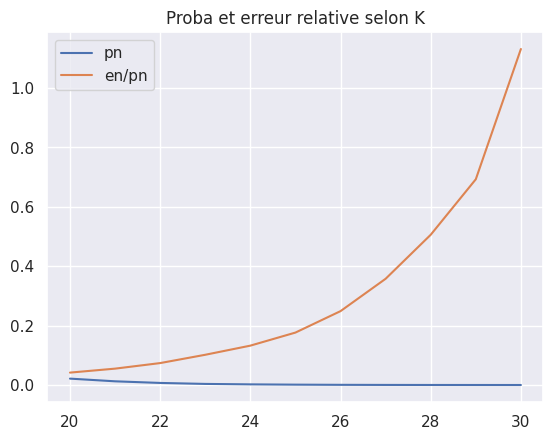

In [6]:
sample_S = simu_S(n, mu, sigma, lmbda)

Ks = np.arange(20,31)
rel_errors = [relative_error(sample_S, k) for k in Ks]

plt.plot(Ks, rel_errors, label=("pn", "en/pn"))
plt.title("Proba et erreur relative selon K")
plt.legend()
plt.show()

### Question: Monte Carlo à précision fixée

Mettre en oeuvre un estimateur de Monte Carlo qui s'arrête dès que l'erreur relative est de 5%. On pourra par exemple introduire la variable aléatoire
\begin{equation*}
    \tau^{(m)} = \inf \bigl\{n \ge 1, e_{n m} \le 0.05 p_{n m} \bigr\},
\end{equation*}
qui dépend d'un paramètre $m$ fixé, par exemple $m = 10\,000$, et renvoyer $p_{\tau^{(m)}}$ ainsi que l'erreur relative et la taille de l'estimateur associé. 
Le paramètre $m$ permet de recalculer l'estimateur et l'erreur uniquement toutes les $m$ itérations et donc de réduire la complexité par rapport au choix naïf $m = 1$. On appelle ce paramètre $m$ la taille du _batch_ (size batch). 
Le nombre d'itérations (la taille de l'échantillon) dans la méthode de Monte Carlo pour un $\tau^{(m)}$ donné est donc $\tau^{(m)} \times m$. 

Définir la fonction qui code cet estimateur Monte Carlo:
```
monte_carlo_relative(mu, sigma, lambd, K, size_batch = 10000, error = 0.05)
```

In [7]:
def monte_carlo_relative(mu, sigma, lambd, K, size_batch=10000, error=0.05):
    sample_S = simu_S(size_batch, mu, sigma, lambd)
    pm, em = relative_error(sample_S, K)

    while(em > error):
        sample_S = np.append(sample_S, simu_S(size_batch, mu, sigma, lambd))
        pm, em = relative_error(sample_S, K)

    return pm, em, sample_S.shape[0]

### Question: complexité en fonction de $K$

Reproduire un tableau de résultat similaire au tableau suivant obtenu avec cet estimateur de Monte Carlo adaptatif jusqu'à l'itération $\tau^{(m)} \times m$ pour une erreur relative de 10% et pour différentes valeurs de $K = 20,\dots,25$.  

Tracer le nombre d'itérations nécessaires en fonction de $K$.

In [8]:
import pandas as pd
df = pd.read_pickle("data/iterations_df.pkl")
df

,Probabilité $p_n$,Erreur relative,Itérations
20,0.021600,0.093277,20000
21,0.013100,0.098219,30000
22,0.007820,0.098733,50000
23,0.003910,0.098927,100000
24,0.002259,0.099908,170000
25,0.001258,0.099186,310000


In [9]:
Ks = np.arange(20,26)
res = [monte_carlo_relative(mu, sigma, lmbda, k, size_batch=10000, error=0.10) for k in Ks]

df = pd.DataFrame(res, index=Ks, columns=["Probabilité pn", "Erreur relative", "Itérations"])
df

,Probabilité pn,Erreur relative,Itérations
20,0.020050,0.096892,20000
21,0.012375,0.087549,40000
22,0.007083,0.094737,60000
23,0.003880,0.099311,100000
24,0.002222,0.097891,180000
25,0.001100,0.098440,360000


## Réduction de variance par préconditionnement 

Pour réduire la variance on teste d'abord l'idée présentée dans l'exercice 1 du TD3, c'est à dire qu'on considère la variable aléatoire 
\begin{equation*}
    M = \inf \bigl\{ r \ge 1, \sum_{i=1}^r X_i > K \bigr\}
\end{equation*}
et la représentation suivante
\begin{equation*}
    p = \mathbf{E} \bigl[\phi(M) \bigr] \quad \text{avec} \quad \phi(m) = \mathbf{P} \bigl[ N \ge m \bigr]
\end{equation*}


### Question: simulation de $M$ 

Ecrire une fonction `simu_M` similaire à la fonction `simu_S` avec l'argument $K$ supplémentaire qui renvoie un échantillon _i.i.d._ de même loi que $M$. 

In [10]:
def simu_M(size, mu, sigma, lambd, K):
    sample_M = np.empty(size)

    for ind in range(size) :
        r = 1
        S = rng.lognormal(mean=mu, sigma=sigma)
        while(S <= K):
            S += rng.lognormal(mean=mu, sigma=sigma)
            r+=1

        sample_M[ind] = r

    return sample_M

### Question: Monte Carlo et ratio de variance 

En utilisant la fonction `monte_carlo` du TP précédent. Calculer le ratio de variance entre l'estimateur $p_n$ et l'estimateur basé sur la représentation $p = \mathbf{E}[\phi(M)]$ où $\phi$ est calculée en utilisant la fonction de survie et la fonction de masse de la loi de Poisson (cf. la documentation de `stats.poisson`). Faire ce calcul pour différentes valeurs de $K$ et $n = 20\,000$

In [11]:
def monte_carlo(sample, proba=0.95):
    moy = np.mean(sample)
    var = np.var(sample, ddof=1)
    n = len(sample)

    quantile = stats.norm.ppf(1-(1-proba)/2)
    borne_inf = moy - quantile * np.sqrt(var/n)
    borne_sup = moy + quantile * np.sqrt(var/n)

    return moy, var, borne_inf, borne_sup

In [12]:
def phi(m):
    N = stats.poisson(lmbda)
    return N.sf(m) + N.pmf(m)
    # proba d'être strictement supérieur + proba d'être égal

In [13]:
n = 20_000
Ks = np.arange(20,26)

res_MC = [monte_carlo(simu_S(n, mu, sigma, lmbda)>k) for k in Ks]

index_y = ["mean", "var", "low", "high"]
df = pd.DataFrame(res_MC, index=Ks, columns=index_y)
df

,mean,var,low,high
20,0.02085,0.020416,0.018870,0.022830
21,0.01245,0.012296,0.010913,0.013987
22,0.00765,0.007592,0.006442,0.008858
23,0.00460,0.004579,0.003662,0.005538
24,0.00135,0.001348,0.000841,0.001859
25,0.00100,0.000999,0.000562,0.001438


In [14]:
res_MC_precond = [monte_carlo(phi(simu_M(n, mu, sigma, lmbda, k))) for k in Ks]
df_precond = pd.DataFrame(res_MC_precond, index=Ks, columns=index_y)
df_precond

,mean,var,low,high
20,0.021136,0.000355,0.020875,0.021397
21,0.012625,0.000159,0.012451,0.012800
22,0.007202,0.000062,0.007093,0.007312
23,0.004051,0.000026,0.003980,0.004122
24,0.002200,0.000009,0.002158,0.002242
25,0.001153,0.000003,0.001129,0.001177


In [15]:
df["var"]/df_precond["var"]

20     57.531594
21     77.431901
22    121.856179
23    174.524896
24    145.182802
25    328.121652
Name: var, dtype: float64

## Réduction de variance par échantillonage d'importance

Pour réduire la variance sans faire exploser la complexité pour les grandes valeurs de $K$ on propose une méthode d'échantillonage d'importance (Importance Sampling) en modifiant la loi de la variable aléatoire $N$ (on peut faire un autre choix, en changeant la loi des $X_i$ ou bien en changeant la loi de $N$ et des $X_i$). Le changement de loi proposé ici repose sur le changement de probabilité, pour $\theta \in \mathbf{R}$
\begin{equation*}
    \frac{\mathrm{d} \mathbf{P}}{\mathrm{d} \mathbf{P}_\theta} = L_\theta \quad \text{avec} \quad L_\theta = \exp\bigl(-\theta N + \psi(\theta) \bigr),
\end{equation*}
où $\psi(\theta) = \log \mathbf{E} \bigl[ \exp(\theta N) \bigr] = \lambda (e^\theta - 1)$. On vérifie par le calcul que la loi de $N$ sous $\mathbf{P}_\theta$ est la loi de Poisson de paramètre $\tilde \lambda = \lambda e^\theta$. Ainsi on a la représentation 
\begin{equation*}
    \mathbf{P}\biggl[ \sum_{i=1}^N X_i > K \biggr] 
    = \mathbf{E}_{\mathbf{P}_\theta} \biggl[ 
    \mathbf{1}_{\sum_{i=1}^N X_i > K } \exp\big(-\theta N+\psi(\theta)\big)
    \bigg]
    \quad \text{avec $N \sim \mathcal{P}(\tilde \lambda)$ sous $\mathbf{P}_\theta$}.
\end{equation*}
Il est d'usage pour la loi de Poisson d'écrire la variable $L_\theta$ à partir de $\lambda$ et $\tilde \lambda$ (la valeur du paramètre de la loi de Poisson sous la nouvelle probabilité) _i.e._ 
\begin{equation*}
    L_\theta = \exp\big(-\theta N + \lambda(e^\theta - 1)\big) 
    = \Bigl(\frac{\lambda}{\tilde \lambda}\Big)^N \exp\big(\tilde \lambda - \lambda\big).
\end{equation*}

### Question: simulation sous $\mathbf{P}_\theta$ 

La loi de $N$ sous $\mathbf{P}_\theta$ est la loi de Poisson de paramètre $\tilde \lambda=\lambda e^\theta$ et la suite $(X_i)_{i \ge 1}$ est indépendante de $N$ donc de $L_\theta$ et n'est donc pas impactée par le changement de probabilité: la loi des $(X_i)_{i \ge 1}$ est inchangée.  
Ecrire une fonction `simu_S_tilde` inspirée de `simu_S` qui prend un paramètre supplémentaire $\theta$ et qui renvoie un échantillon de $\sum_{i=1}^{N} X_i$ sous $\mathbf{P}_\theta$.

In [16]:
def simu_S_tilde(size, mu, sigma, lambd, theta):
    lmbda_tilde = lambd*np.exp(theta)
    sample_N_tilde = rng.poisson(size=size,lam=lmbda_tilde)
    sample_S_tilde = np.empty(size)

    for ind,N_tilde in enumerate(sample_N_tilde) :
        Xn = rng.lognormal(mean=mu, sigma=sigma, size=N_tilde)
        sample_S_tilde[ind] = np.sum(Xn)

    return sample_S_tilde, sample_N_tilde

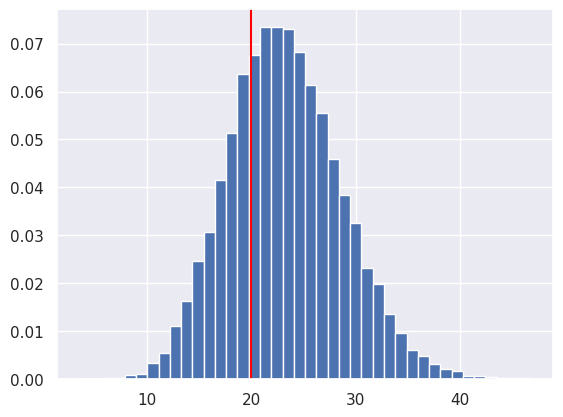

In [17]:
K = 20
theta = 0.7
sample_S_tilde = simu_S_tilde(n, mu, sigma, lmbda, theta)[0]

plt.hist(sample_S_tilde, bins=40, density=True)
plt.axvline(K, color="red")
plt.show()

### Question: Monte Carlo sous $\mathbf{P}_\theta$

Comparer pour différentes valeurs de $K$, avec $\theta = 0.7$, l'estimateur de Monte Carlo basé sur la représentation 
\begin{equation*}
    \mathbf{P}\biggl[ \sum_{i=1}^N X_i > K \biggr] 
    = \mathbf{E}\biggl[\mathbf{1}_{\sum_{i=1}^{\tilde N} X_i > K } 
    \bigl(\frac{\lambda}{\tilde \lambda} \bigr)^{\tilde N} 
    \exp(\tilde \lambda - \lambda)
    \biggr] \quad \text{avec $\tilde N \sim \mathcal{P}(\tilde \lambda)$}.
\end{equation*}
Pour $K = 22$ le ratio de variance est de l'ordre de 16-17.

Que se passe-t-il si le paramètre $\theta$ est mal choisi? (prendre par exemple $\theta = 1.2$ puis $\theta = 1.5$, et $\theta = -0.1$...)

In [19]:
theta = 0.7
Ks = np.arange(20,26)
res_IS = []


for K in Ks:
    lmbda_tilde = lmbda*np.exp(theta)
    sample_tilde = simu_S_tilde(n, mu, sigma, lmbda, theta)

    sample = (sample_tilde[0]>K) * np.power(lmbda/lmbda_tilde, sample_tilde[1]) * np.exp(lmbda_tilde - lmbda)
    sample_mc = monte_carlo(sample)
    res_IS.append(sample_mc)

index_y = ["mean", "var", "low", "high"]
df_IS = pd.DataFrame(res_IS, index=Ks, columns=index_y)
df_IS


,mean,var,low,high
20,0.021409,0.003546,0.020584,0.022235
21,0.012462,0.001095,0.012004,0.012921
22,0.007451,0.000465,0.007152,0.007749
23,0.003973,0.000133,0.003814,0.004133
24,0.002156,0.000049,0.002059,0.002253
25,0.001137,0.000016,0.001081,0.001193


In [20]:
df["var"]/df_IS["var"]

20     5.757514
21    11.226883
22    16.323180
23    34.523897
24    27.319540
25    61.101065
Name: var, dtype: float64

## Calcul de sensibilités 

On utilisera la notation $S^{(\lambda)}$ pour indiquer la dépendance de variable aléatoire $S = \sum_{i=1}^{N} X_i$ en le paramètre $\lambda > 0$ (paramètre de la loi de Poisson sous-jacente). On s'intéresse à la sensibilité de la probabilité $p$ en fonction de lambda c'est à dire 
\begin{equation*}
    \frac{\partial}{\partial \lambda} p(\lambda) = \frac{\partial}{\partial \lambda} \mathbf{P} \bigl[ S^{\lambda} > K \bigl]
\end{equation*}

### Différences finies
Implémenter l'estimateur Monte Carlo basé sur les différences finies d'ordre 2 
\begin{equation*}
    \frac{\partial}{\partial \lambda} p(\lambda) = \frac{p(\lambda + h) - p(\lambda- h)}{2h} + \mathcal{O}(h^2)
\end{equation*}
Comme vu en cours, il y a plusieurs façon d'implémenter l'estimateur Monte Carlo dans ce cadre biaisé. 

- Le premier estimateur naïf $J^{(1)}_{n,h}(\lambda)$ est basé sur des réalisations indépendantes de $S^{(\lambda+h)}$ et $S^{(\lambda-h)}$ et n'est pas efficace: la variance explose lorsque $h$ tend vers 0. Ainsi on pose
\begin{equation*}
    J^{(1)}_{n, h}(\lambda) = \frac{1}{2 h n} \bigl( \sum_{k = 1}^n \mathbf{1}_{\{S^{(\lambda+h)}_k > K\}} - \sum_{k = 1}^n  \mathbf{1}_{\{\tilde S^{(\lambda-h)}_k > K\}} \bigr),
\end{equation*}
où $(S^{(\lambda+h)}_k)_{k \ge 1}$ et $(\tilde S^{(\lambda-h)}_k)_{k \ge 1}$ sont des suites indépendantes de variables aléatoires _i.i.d._.

- Le deuxième estimateur $J^{(2)}_{n,h}(\lambda)$ utilise des réalisations fortements corrélées de la loi de Poisson au sens suivant: on utilise la même réalisation uniforme $U$ pour constuire deux réalisations $N^{(\lambda+h)}$ et $N^{(\lambda-h)}$ en utilisant la méthode de l'inverse de la fonction de répartition. Dans ce deuxième estimateur, les lois log-normales sont indépendantes. On a donc
\begin{equation*}
    J^{(2)}_{n, h}(\lambda) = \frac{1}{2 h n} \sum_{k = 1}^n \bigl(\mathbf{1}_{\{S^{(\lambda+h)}_k > K\}} - \mathbf{1}_{\{\bar S^{(\lambda-h)}_k > K\}} \bigr),
\end{equation*}
où pour $k \ge 1$, $S^{(\lambda+h)}_k = \sum_{i = 1}^{G(\lambda+h, U_k)} X_{i,k}$ et $\bar S^{(\lambda-h)}_k = \sum_{i = 1}^{G(\lambda-h, U_k)} \bar X_{i,k}$ avec $G(\lambda, u)$ l'inverse généralisée de la loi de Poisson de paramètre $\lambda$, $(U_k)_{k \ge 1}$ suite _i.i.d._ uniforme sur $[0,1]$ indépendante de $(X_{i,k})_{i\ge1, k\ge 1}$ et $(\bar X_{i,k})_{i\ge1, k\ge 1}$ deux suites (doublement indicées) _i.i.d._ de loi log-normale (de paramètres $\mu$ et $\sigma$ inchangés).

- Un troisième estimateur $J^{(3)}_{n,h}(\lambda)$ utilise des réalisations fortements corrélées de la loi de Poisson et des variables aléatoires log-normales communes. 
\begin{equation*}
    J^{(3)}_{n, h}(\lambda) = \frac{1}{2 h n} \sum_{k = 1}^n \bigl(\mathbf{1}_{\{S^{(\lambda+h)}_k > K\}} - \mathbf{1}_{\{S^{(\lambda-h)}_k > K\}} \bigr),
\end{equation*}
où pour $k \ge 1$, $S^{(\lambda+h)}_k = \sum_{i = 1}^{G(\lambda+h, U_k)} X_{i,k}$ et $S^{(\lambda-h)}_k = \sum_{i = 1}^{G(\lambda-h, U_k)} X_{i,k}$ avec $G(\lambda, u)$ l'inverse généralisée de la loi de Poisson de paramètre $\lambda$, $(U_k)_{k \ge 1}$ suite _i.i.d._ uniforme sur $[0,1]$ indépendante de $(X_{i,k})_{i\ge1, k\ge 1}$ une suite (doublement indicée) _i.i.d._ de loi log-normale.

### Question: plusieurs estimateurs des différences finies 

On fixe les paramètres $\lambda = 10$, $\mu = 0.1$, $\sigma = 0.3$ et $K = 20$.
Programmer ces 3 estimateurs pour différentes valeurs de $h$ (par exemple, $h=1$, 0.5, 0.1 et 0.01), et donner le résultat des estimateurs Monte Carlo avec $n = 50\,000$.

Que se passe-t-il lorsque $h$ tend vers 0? Comparez le comportement pour ces 3 estimateurs. Il est très important de bien interpréter ces tableaux de résultats et de conclure qu'il faut utiliser l'estimateur $J^{(3)}_{n, h}(\lambda)$ et en aucun cas l'estimateur $J^{(1)}_{n,h}(\lambda)$.

_Remarque_: on considère ici uniquement l'étude de l'erreur statistique dûe à la méthode de Monte Carlo. On ne considère pas l'erreur de biais qui décroît lorsque $h$ tend vers 0 et qui est peut-être non négligeable pour $h = 1$. Les IC construits ici sont biaisés et on ne peut pas affirmer que la vraie valeur est dans l'IC à 95% (au moins pour les grandes valeurs de $h$). 